# 0. Nettoyage et Préparation des Données

Ce notebook gère :
1. Téléchargement du dataset Kaggle (movie scripts corpus)
2. Chargement des métadonnées (titres, années)
3. Parsing et nettoyage massif des scripts avec Regex
4. Liaison scripts ↔ métadonnées
5. Sauvegarde des données nettoyées dans `data/processed/`

In [7]:
# Installation des dépendances si nécessaire
import sys
import subprocess

try:
    import kagglehub
except ModuleNotFoundError:
    print("Installation de kagglehub...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "kagglehub"])
    import kagglehub

import os
import sys
import pandas as pd
import numpy as np
import glob
from pathlib import Path

# Ajouter le dossier src au path
sys.path.append('../src')

print("✓ Imports réussis")

✓ Imports réussis


## 1. Téléchargement du Dataset

In [8]:
# Télécharger le dataset de scripts de films
print("Téléchargement du dataset Kaggle...")
dataset_path = kagglehub.dataset_download("gufukuro/movie-scripts-corpus")
print(f"✓ Dataset téléchargé dans : {dataset_path}")

Téléchargement du dataset Kaggle...
✓ Dataset téléchargé dans : /Users/antoineollivier/.cache/kagglehub/datasets/gufukuro/movie-scripts-corpus/versions/1


## 2. Chargement des Métadonnées

In [9]:
# Recherche du fichier CSV contenant les métadonnées avec l'année
print("Recherche des métadonnées...")

metadata_dir = os.path.join(dataset_path, "movie_metadata")
all_csvs = glob.glob(os.path.join(metadata_dir, "*.csv"))
all_csvs += glob.glob(os.path.join(dataset_path, "*.csv"))

df_meta = None
year_col = None

for csv_file in all_csvs:
    try:
        temp_df = pd.read_csv(csv_file)
        temp_df.columns = [c.strip() for c in temp_df.columns]
        
        # Chercher une colonne contenant 'year' ou 'date'
        candidates = [c for c in temp_df.columns if 'year' in c.lower() or 'date' in c.lower()]
        
        if candidates and len(temp_df) > 500:
            print(f"✓ Métadonnées trouvées : {os.path.basename(csv_file)}")
            print(f"  Colonnes : {list(temp_df.columns)}")
            df_meta = temp_df
            year_col = candidates[0]
            break
    except Exception as e:
        print(f"  Erreur sur {csv_file}: {e}")

if df_meta is None:
    raise ValueError("Impossible de trouver un fichier CSV avec une colonne d'année")

print(f"\n✓ {len(df_meta)} films trouvés dans les métadonnées")

Recherche des métadonnées...
✓ Métadonnées trouvées : movie_meta_data.csv
  Colonnes : ['imdbid', 'title', 'akas', 'year', 'metascore', 'imdb user rating', 'number of imdb user votes', 'awards', 'opening weekend', 'producers', 'budget', 'script department', 'production companies', 'writers', 'directors', 'casting directors', 'cast', 'countries', 'age restrict', 'plot', 'plot outline', 'keywords', 'genres', 'taglines', 'synopsis']

✓ 2858 films trouvés dans les métadonnées


In [10]:
# Nettoyage de la colonne année
df_meta['release_year'] = pd.to_numeric(df_meta[year_col], errors='coerce')
df_meta = df_meta.dropna(subset=['release_year'])
df_meta['decade'] = (df_meta['release_year'] // 10) * 10

# Filtrer sur la période d'intérêt (1960-2020)
df_meta = df_meta[(df_meta['release_year'] >= 1960) & (df_meta['release_year'] <= 2020)]

print(f"✓ {len(df_meta)} films entre 1960 et 2020")
print(f"\nDistribution par décennie :")
print(df_meta['decade'].value_counts().sort_index())

✓ 2681 films entre 1960 et 2020

Distribution par décennie :
decade
1960     57
1970    117
1980    288
1990    568
2000    757
2010    867
2020     27
Name: count, dtype: int64


## 3. Localisation des Scripts

In [11]:
# Chercher le dossier contenant les scripts .txt
script_path = None

for root, dirs, files in os.walk(dataset_path):
    txt_files = [f for f in files if f.endswith('.txt')]
    if len(txt_files) > 100:
        script_path = root
        print(f"✓ Scripts trouvés dans : {script_path}")
        print(f"  Nombre de fichiers .txt : {len(txt_files)}")
        break

if script_path is None:
    raise ValueError("Impossible de trouver le dossier contenant les scripts .txt")

✓ Scripts trouvés dans : /Users/antoineollivier/.cache/kagglehub/datasets/gufukuro/movie-scripts-corpus/versions/1/screenplay_data/data/BERT_annotations/BERT_annotations
  Nombre de fichiers .txt : 1998


## 4. Parsing et Nettoyage des Scripts

In [12]:
# Importer nos fonctions de parsing
import re

def clean_script_text(raw_text):
    """
    Nettoie le texte brut d'un script de film.
    """
    # Supprimer les métadonnées et en-têtes courants
    text = re.sub(r'(Written by|Screenplay by|Script by).*?\n', '', raw_text, flags=re.IGNORECASE)
    text = re.sub(r'(FADE IN:|FADE OUT:|CUT TO:)', '', text)
    text = re.sub(r'\(.*?\)', '', text)  # Supprimer les indications scéniques
    text = re.sub(r'INT\.|EXT\.', '', text)  # Supprimer INT./EXT.
    text = re.sub(r'^[A-Z\s]+$', '', text, flags=re.MULTILINE)  # Supprimer les noms de personnages en majuscules seuls
    text = re.sub(r'\s+', ' ', text)  # Normaliser les espaces
    text = text.strip()
    
    return text

def match_script_to_metadata(row, script_directory):
    """
    Trouve et charge le script correspondant à un film.
    """
    if not isinstance(row.get('title'), str):
        return None
    
    # Nettoyer le titre pour la recherche de fichier
    safe_title = row['title'].replace(':', '').replace('?', '').strip()
    
    try:
        # Chercher des fichiers contenant le titre
        potential_files = glob.glob(os.path.join(script_directory, f"*{safe_title}*.txt"))
        
        if potential_files:
            # Prendre le premier match
            script_file = potential_files[0]
            
            # Lire et nettoyer le script
            with open(script_file, 'r', encoding='utf-8', errors='ignore') as f:
                raw_text = f.read()
            
            clean_text = clean_script_text(raw_text)
            
            return {
                'filepath': script_file,
                'filename': os.path.basename(script_file),
                'clean_text': clean_text,
                'word_count': len(clean_text.split())
            }
    except Exception as e:
        return None
    
    return None

In [13]:
# Charger les scripts (peut prendre plusieurs minutes)
print("Chargement et nettoyage des scripts...")
print("(Cela peut prendre 5-10 minutes pour ~1000 films)")

# Pour tester rapidement, on peut limiter à N films
# df_sample = df_meta.head(100)  # Décommenter pour tester
df_sample = df_meta  # Utiliser tout le dataset

script_data = []
for idx, row in df_sample.iterrows():
    if idx % 100 == 0:
        print(f"  Progression: {idx}/{len(df_sample)}")
    
    script_info = match_script_to_metadata(row, script_path)
    if script_info:
        script_data.append({
            'title': row['title'],
            'release_year': row['release_year'],
            'decade': row['decade'],
            **script_info
        })

df_scripts = pd.DataFrame(script_data)
print(f"\n✓ {len(df_scripts)} films avec scripts chargés et nettoyés")

Chargement et nettoyage des scripts...
(Cela peut prendre 5-10 minutes pour ~1000 films)
  Progression: 0/2681
  Progression: 100/2681
  Progression: 200/2681
  Progression: 300/2681
  Progression: 500/2681
  Progression: 600/2681
  Progression: 800/2681
  Progression: 900/2681
  Progression: 1000/2681
  Progression: 1100/2681
  Progression: 1200/2681
  Progression: 1300/2681
  Progression: 1400/2681
  Progression: 1500/2681
  Progression: 1600/2681
  Progression: 1700/2681
  Progression: 1800/2681
  Progression: 1900/2681
  Progression: 2000/2681
  Progression: 2100/2681
  Progression: 2200/2681
  Progression: 2300/2681
  Progression: 2400/2681
  Progression: 2500/2681
  Progression: 2600/2681
  Progression: 2700/2681
  Progression: 2800/2681

✓ 1787 films avec scripts chargés et nettoyés



=== STATISTIQUES ===
Nombre total de films : 1787

Distribution par décennie :
decade
1960     34
1970     80
1980    187
1990    378
2000    521
2010    575
2020     12
Name: count, dtype: int64

Nombre moyen de mots par script : 27826
Médiane : 27664


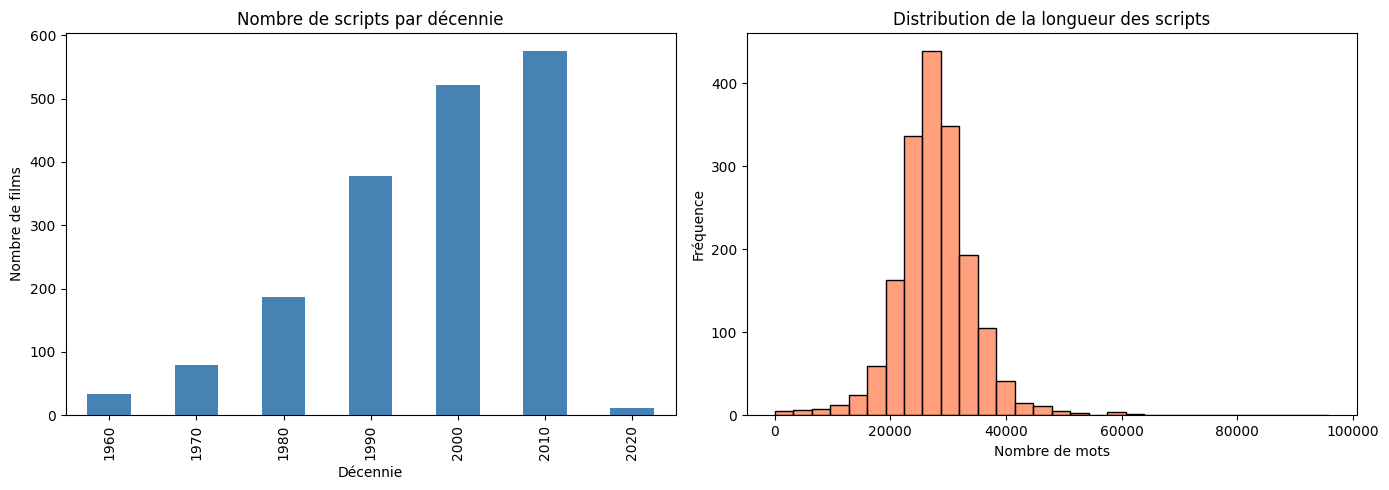

In [14]:
# Statistiques descriptives
print("\n=== STATISTIQUES ===")
print(f"Nombre total de films : {len(df_scripts)}")
print(f"\nDistribution par décennie :")
print(df_scripts['decade'].value_counts().sort_index())
print(f"\nNombre moyen de mots par script : {df_scripts['word_count'].mean():.0f}")
print(f"Médiane : {df_scripts['word_count'].median():.0f}")

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme par décennie
df_scripts['decade'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Nombre de scripts par décennie')
axes[0].set_xlabel('Décennie')
axes[0].set_ylabel('Nombre de films')

# Distribution des longueurs de script
sns.histplot(df_scripts['word_count'], bins=30, ax=axes[1], color='coral')
axes[1].set_title('Distribution de la longueur des scripts')
axes[1].set_xlabel('Nombre de mots')
axes[1].set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

## 5. Sauvegarde des Données Nettoyées

In [15]:
# Créer le dossier de sortie
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

# Sauvegarder en CSV (sans le texte complet pour économiser l'espace)
df_metadata = df_scripts[['title', 'release_year', 'decade', 'filename', 'word_count']].copy()
df_metadata.to_csv(output_dir / 'scripts_metadata.csv', index=False)
print(f"✓ Métadonnées sauvegardées : {output_dir / 'scripts_metadata.csv'}")

# Sauvegarder le DataFrame complet avec le texte en pickle (plus efficace)
df_scripts.to_pickle(output_dir / 'scripts_clean.pkl')
print(f"✓ Scripts complets sauvegardés : {output_dir / 'scripts_clean.pkl'}")

print("\n✅ Nettoyage terminé ! Données prêtes pour l'analyse.")

✓ Métadonnées sauvegardées : ../data/processed/scripts_metadata.csv
✓ Scripts complets sauvegardés : ../data/processed/scripts_clean.pkl

✅ Nettoyage terminé ! Données prêtes pour l'analyse.


## 6. Aperçu des Données

In [16]:
# Afficher quelques exemples
print("Aperçu des données :")
display(df_scripts[['title', 'release_year', 'decade', 'word_count']].head(10))

# Exemple de texte nettoyé
print("\n=== Exemple de script nettoyé ===")
print(f"Film : {df_scripts.iloc[0]['title']}")
print(f"Année : {df_scripts.iloc[0]['release_year']}")
print(f"\nExtrait (300 premiers caractères) :")
print(df_scripts.iloc[0]['clean_text'][:300] + "...")

Aperçu des données :


,title,release_year,decade,word_count
0,A Night at the Roxbury,1998,1990,24461
1,At First Sight,1999,1990,32234
2,The Avengers,1998,1990,27799
3,Bamboozled,2000,2000,28493
4,The Big Lebowski,1998,1990,26138
5,Braveheart,1995,1990,31569
6,The Breakfast Club,1985,1980,15870
7,Chill Factor,1999,1990,16884
8,Hannah and Her Sisters,1986,1980,45590
9,The Last of the Mohicans,1992,1990,29234



=== Exemple de script nettoyé ===
Film : A Night at the Roxbury
Année : 1998

Extrait (300 premiers caractères) :
dialog: text: A NIGHT AT THE ROXBURY dialog: dialog: Steve Koren dialog: Will Ferrell dialog: & dialog: Chris Kattan dialog: June 2, 1997 speaker_heading: scene_heading: PANORAMIC VIEW OF LOS ANGELES - SUNSET text: As we hear "What is Love" by HADDAWAY -- night falls and text: partytime begins. scen...
